In [5]:
# system
import glob
import time
import os
import logging
import sys

# scipy
import numpy as np # type: ignore
from scipy import signal # type: ignore
from scipy.optimize import curve_fit # type: ignore

# matplotlib
import matplotlib.pyplot as plt # type: ignore

# grandlib
import grand.dataio.root_trees as rt # type: ignore

# import tools
import database.tools as tools


%matplotlib inline
plt.style.use('/pbs/home/p/pcorrea/tools/matplotlib_style_sans-serif.txt')

In [6]:
sig_dir   = '/sps/grand/pcorrea/nutrig/database/sig/zhaires_proton_rfv2_th1_35_th2_25/'
sig_files = sorted( glob.glob( os.path.join(sig_dir,'*.npz') ) )

In [3]:
snr        = np.zeros(0)
file_idx   = np.zeros(0)
file_entry = np.zeros(0)

for i, sig_file in enumerate(sig_files[::5]):
    with np.load(sig_file) as f:
        mask_trig = np.where(f['pretrig_flags']==0,False,True)
        snr_new   = np.max(f['snr'][...,:2],axis=1) # SNR of event = maximum of X/Y SNR (= where you triggered)
        mask_snr  = np.where(snr_new<10,True,False)
        
        mask  = np.logical_and(mask_snr,mask_trig)

        if np.any(mask):
            entries_mask   = np.arange( len(mask) )[mask]
            n_entries_mask = len( mask[mask] )

            snr        = np.hstack( ( snr, snr_new[mask] ) )
            file_idx   = np.hstack( ( file_idx, i*np.ones(n_entries_mask) ) )
            file_entry = np.hstack( ( file_entry, entries_mask ) )

#return snr, file_idx, file_entry

In [12]:
snr = np.zeros((0,3))
inj_time = np.zeros(0)
trig_time = np.zeros(0)
trig_flag = np.zeros(0)
energy = np.zeros(0)
sig_traces = np.zeros((0,3,1024))

max_traces = np.zeros((0,3))

for sig_file in sig_files[::10]:
    with np.load(sig_file) as f:
        mask_trig = np.where(f['pretrig_flags']==0,False,True)

        snr = np.vstack((snr,f['snr'][mask_trig]))
        inj_time = np.hstack((inj_time,f['inj_pulse_times'][mask_trig]))
        trig_time = np.hstack((trig_time,f['pretrig_times'][mask_trig]))
        trig_flag = np.hstack((trig_flag,f['pretrig_flags'][mask_trig]))
        sig_traces = np.vstack((sig_traces,f['traces'][mask_trig]))

        rms = tools.rms(f['traces'][mask_trig],axis=2)
        max_trace = np.max(np.abs(f['traces'][mask_trig]),axis=2)

        max_traces = np.vstack((max_traces,max_trace/rms))

        energy_sim = float(os.path.basename(sig_file).split('_')[7]) * np.ones(mask_trig[mask_trig].shape)
        energy = np.hstack((energy,energy_sim))

weights_energy = ( energy/np.min(energy) )**-3

[3.68504864 2.91021111 2.08559111]


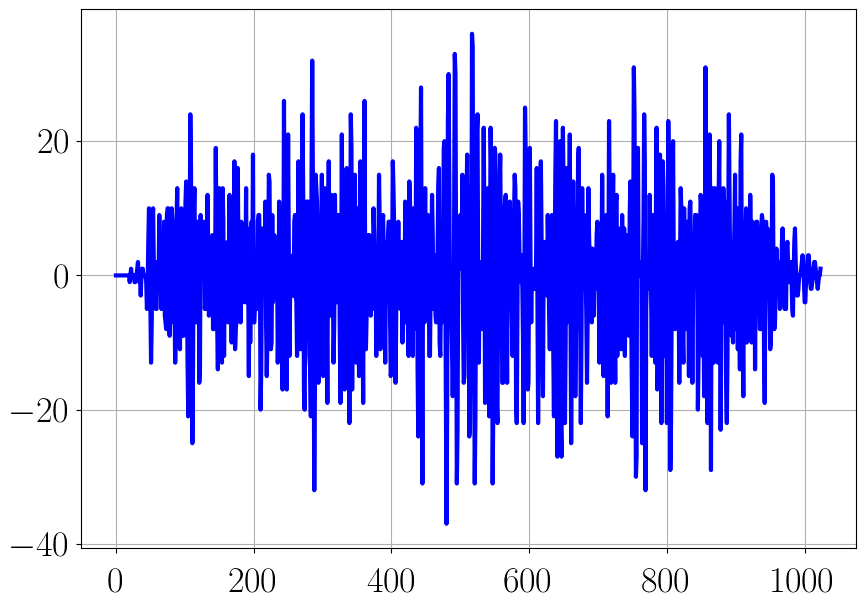

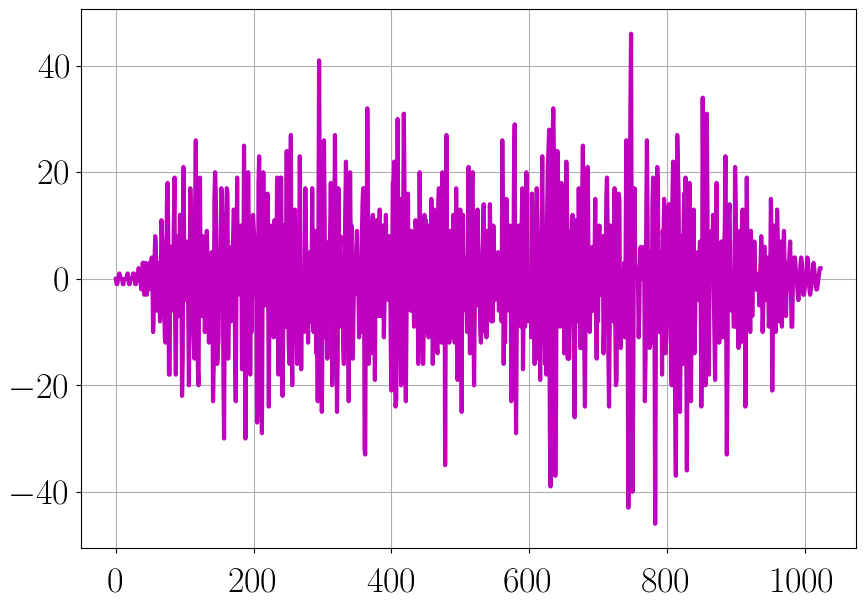

[2.21107388 3.2650729  2.08372175]


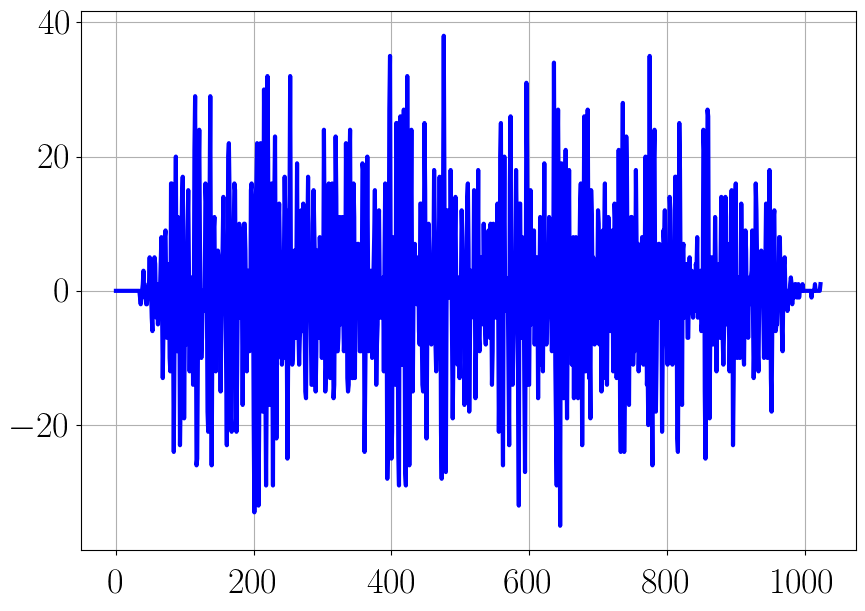

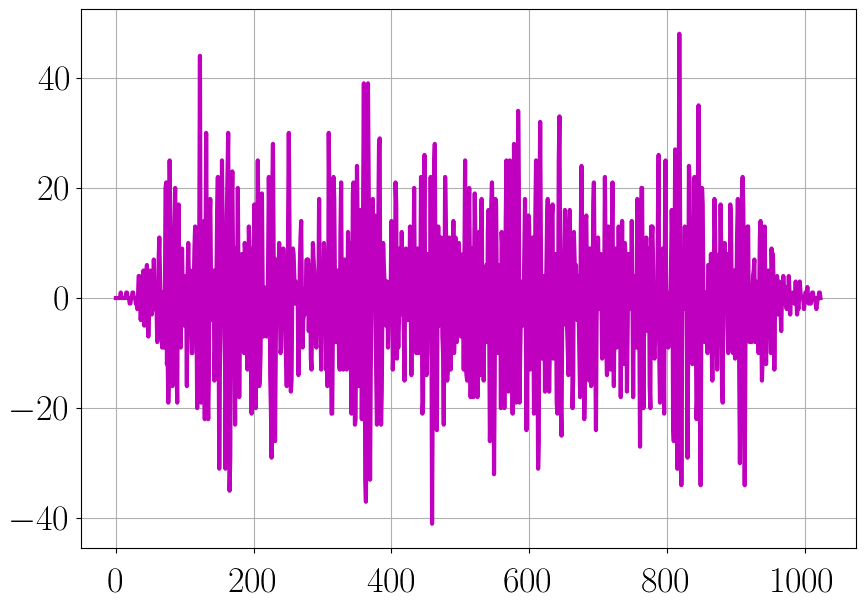

[3.92558486 2.69140207 2.70079759]


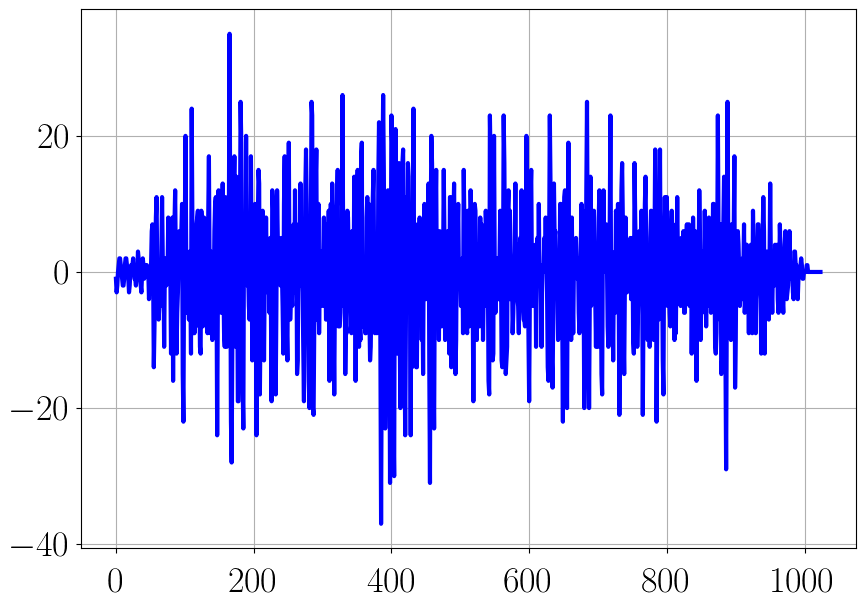

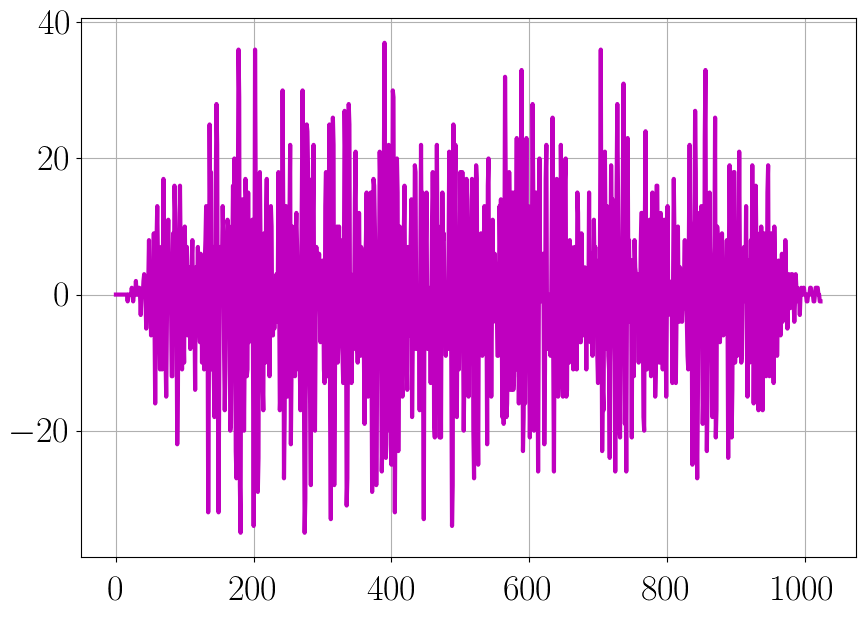

[3.94290206 2.80350794 1.79764505]


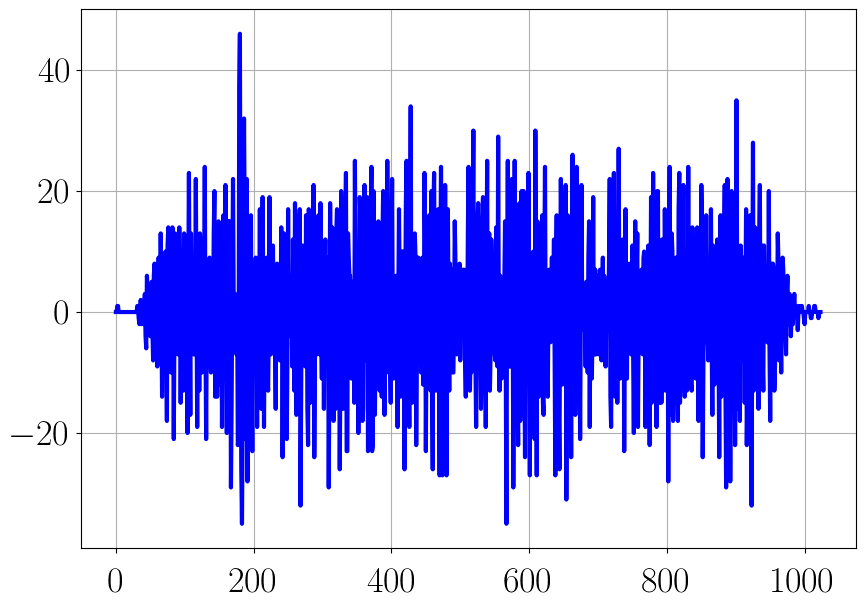

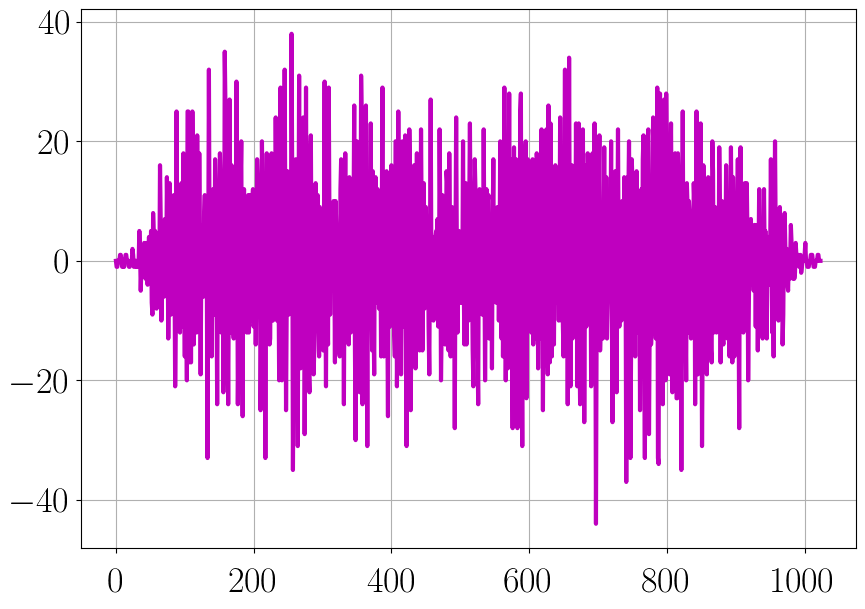

[2.62178018 2.92632415 2.23648673]


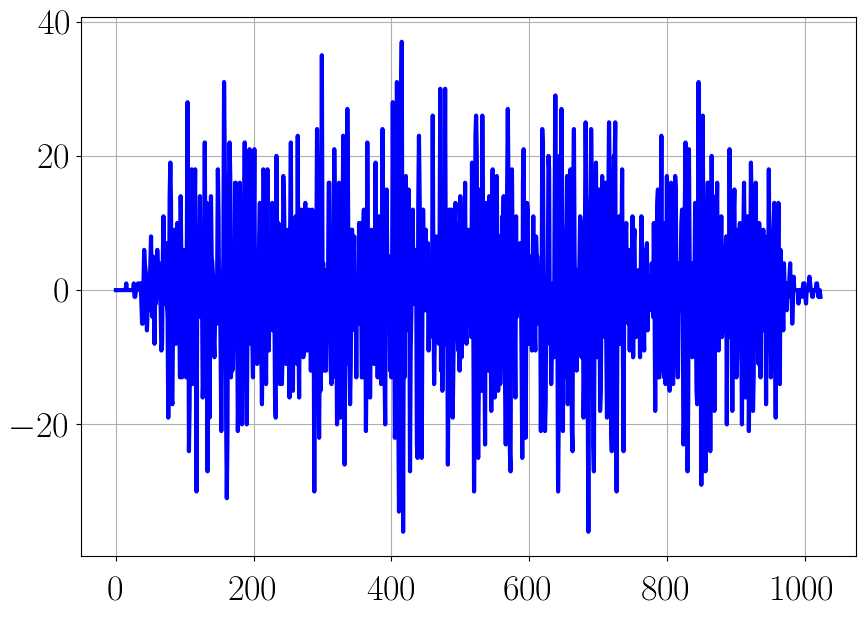

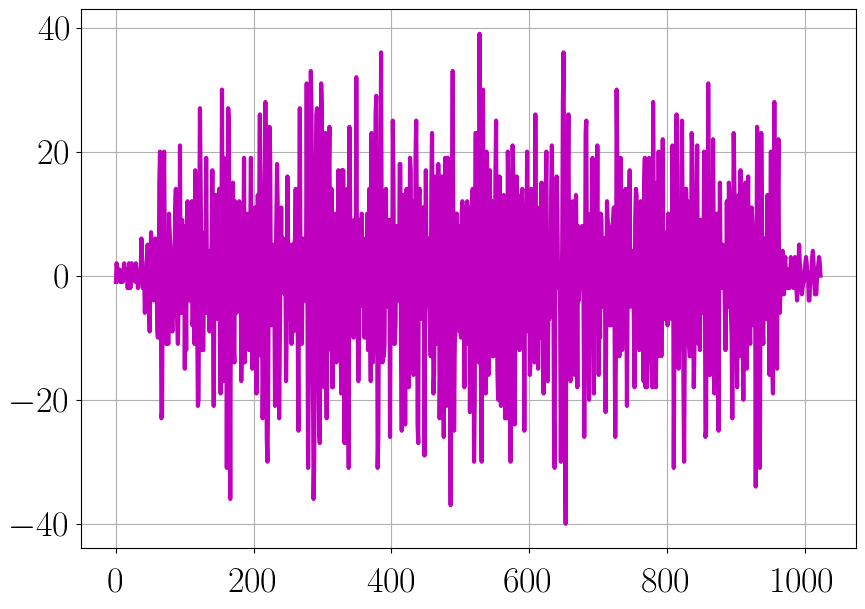

[2.91081199 3.05976449 2.61224987]


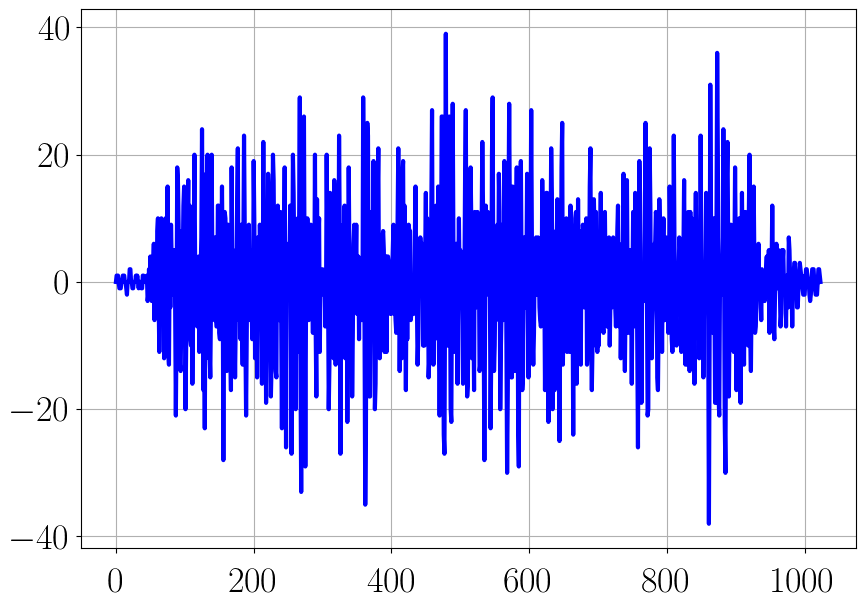

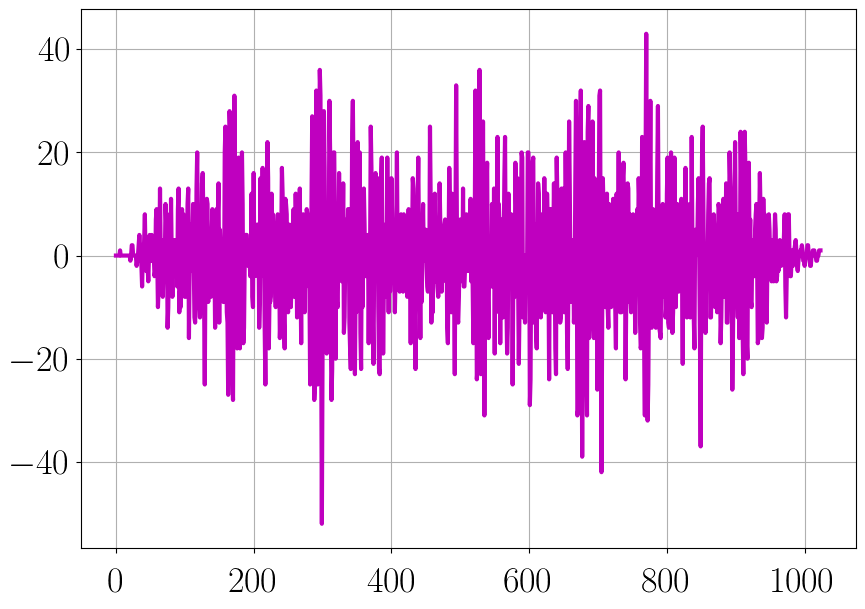

[2.75015645 3.52851544 3.26476182]


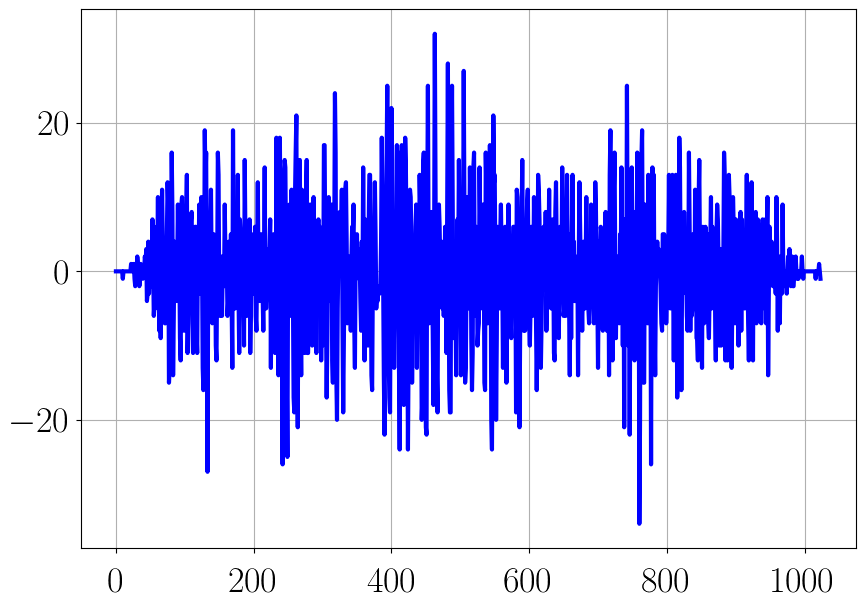

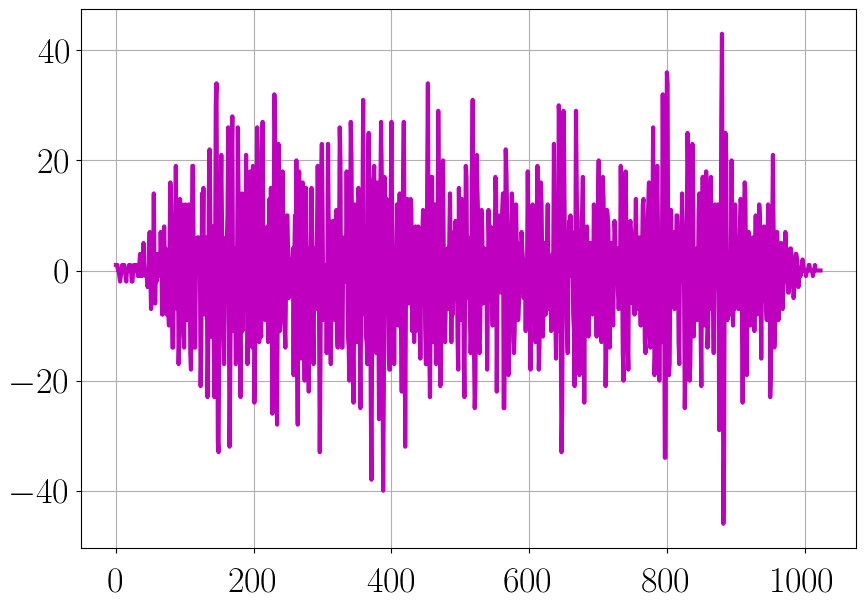

[2.64555895 2.40114933 2.85889478]


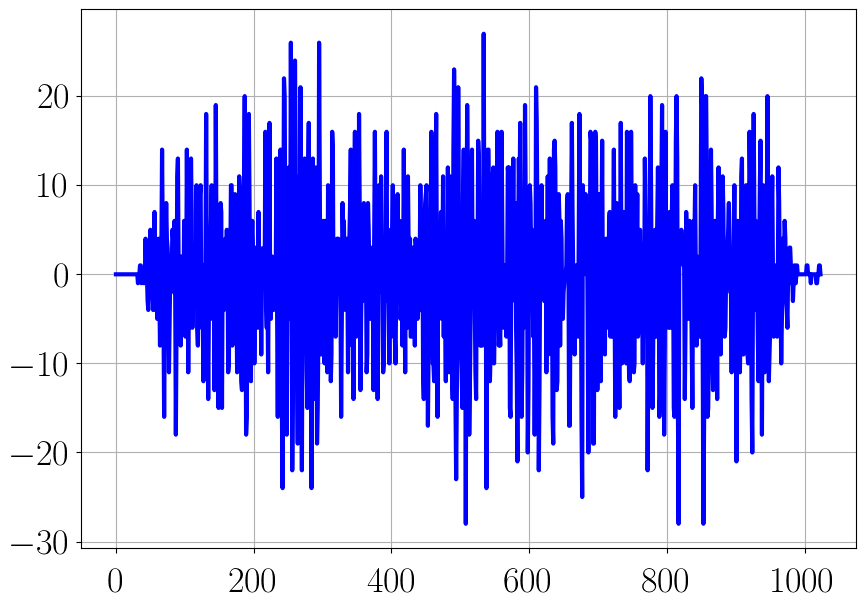

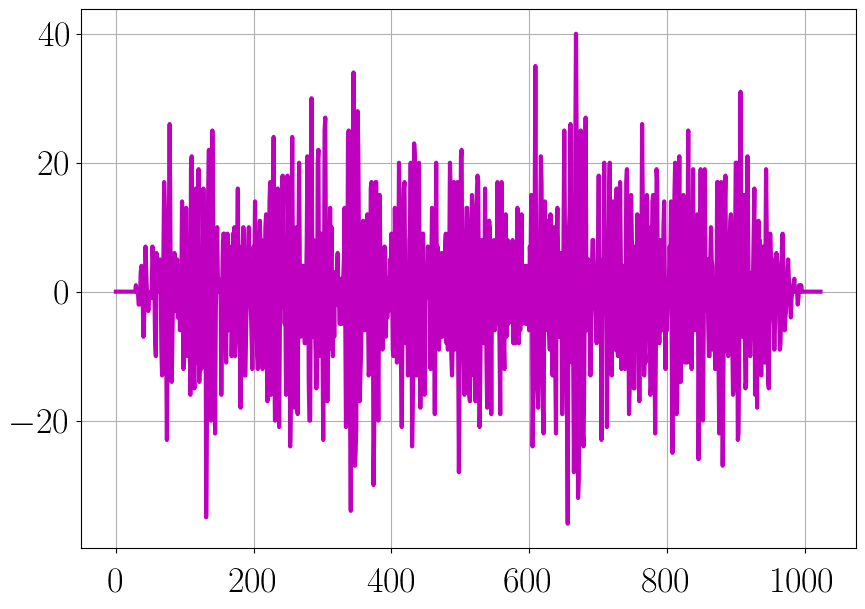

[2.52057176 3.8587311  1.94848119]


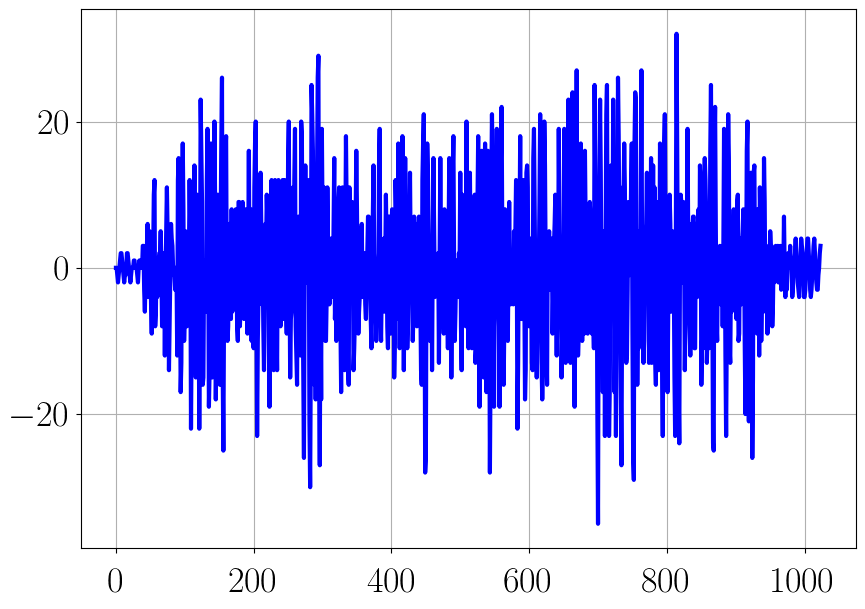

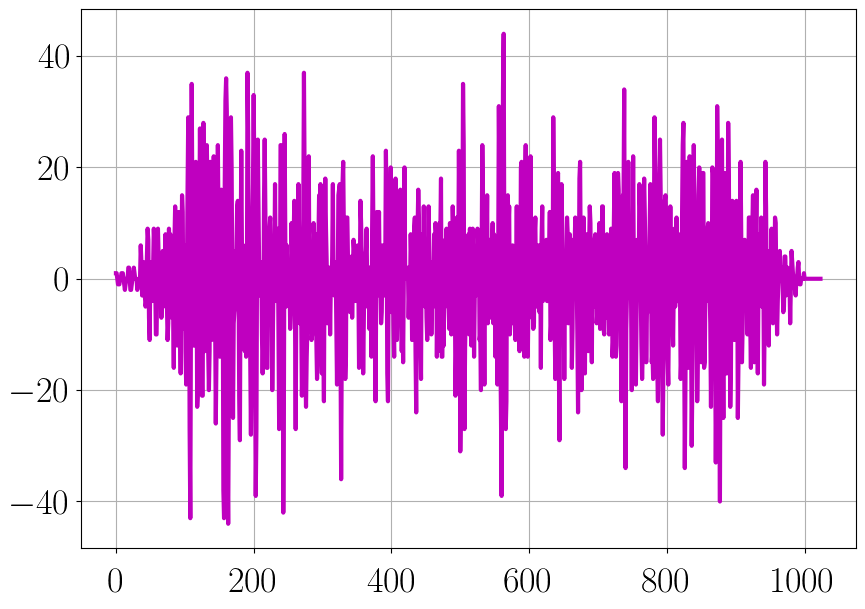

[2.65228075 3.72617637 3.15534564]


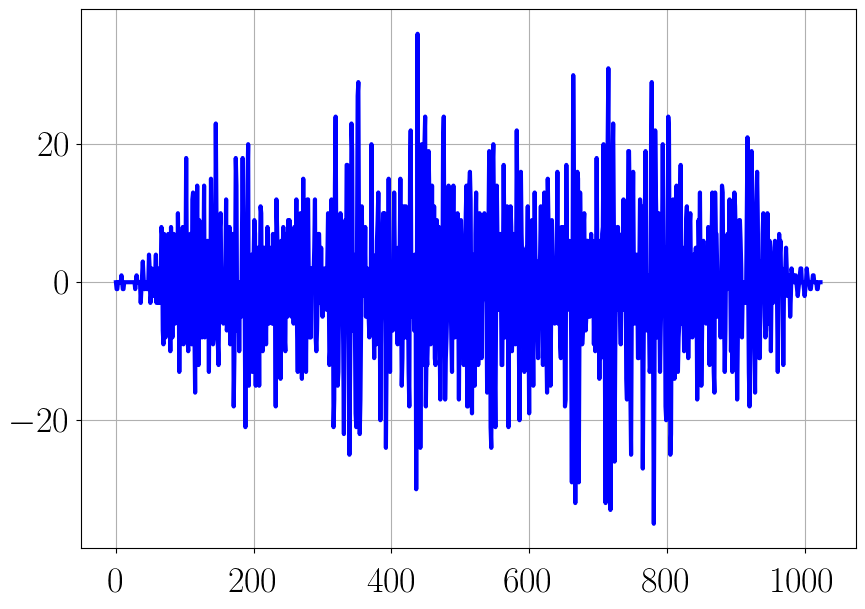

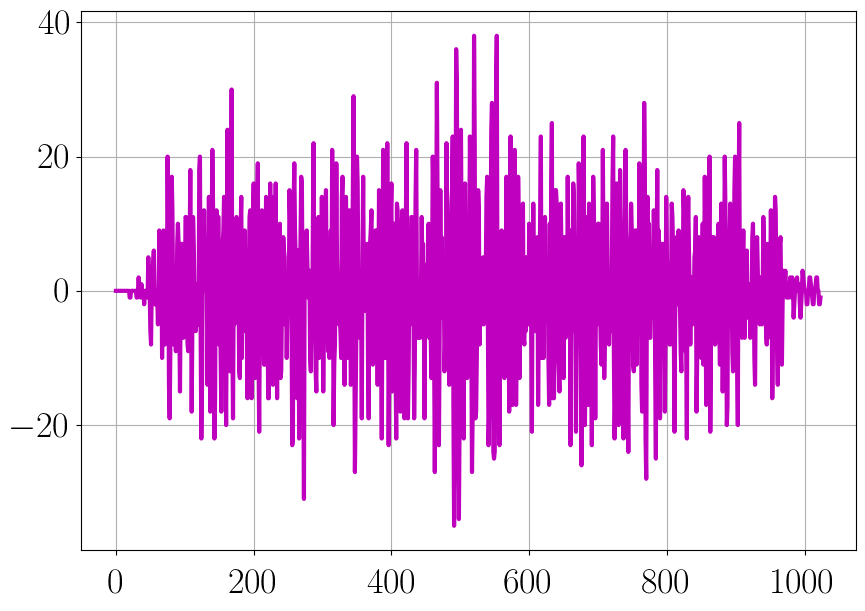

[2.44725571 3.05969015 2.30888162]


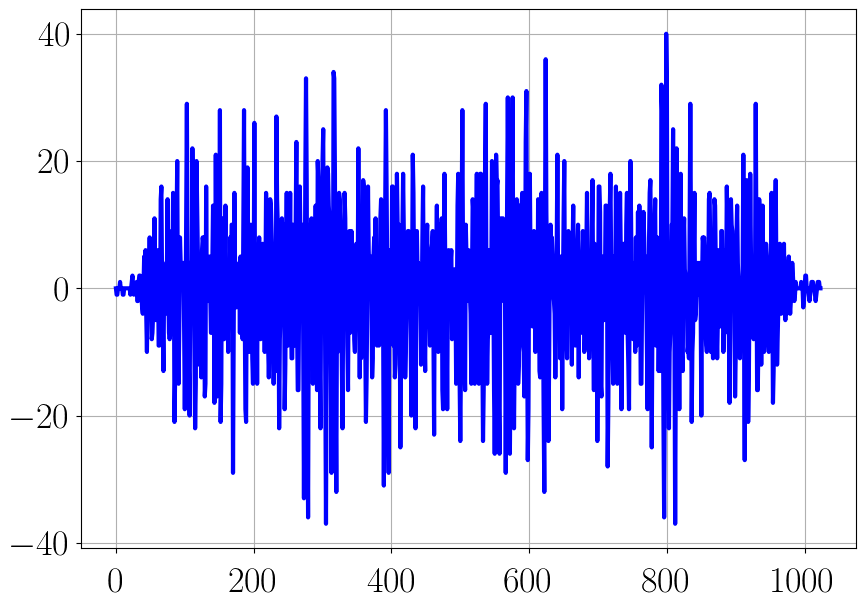

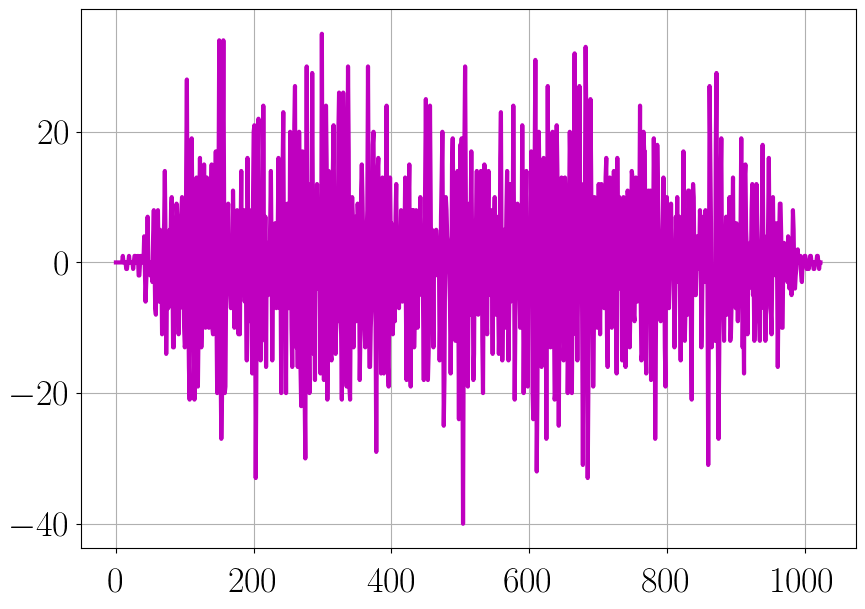

In [8]:
i=0
for j, sig_trace in enumerate(sig_traces):
    if i > 10:
        break
    if np.all(snr[j]<4):
        print(snr[j])
        plt.plot(sig_trace[0],color='b')
        plt.show()
        plt.plot(sig_trace[1],color='m')
        plt.show()
        i+=1

<BarContainer object of 399 artists>

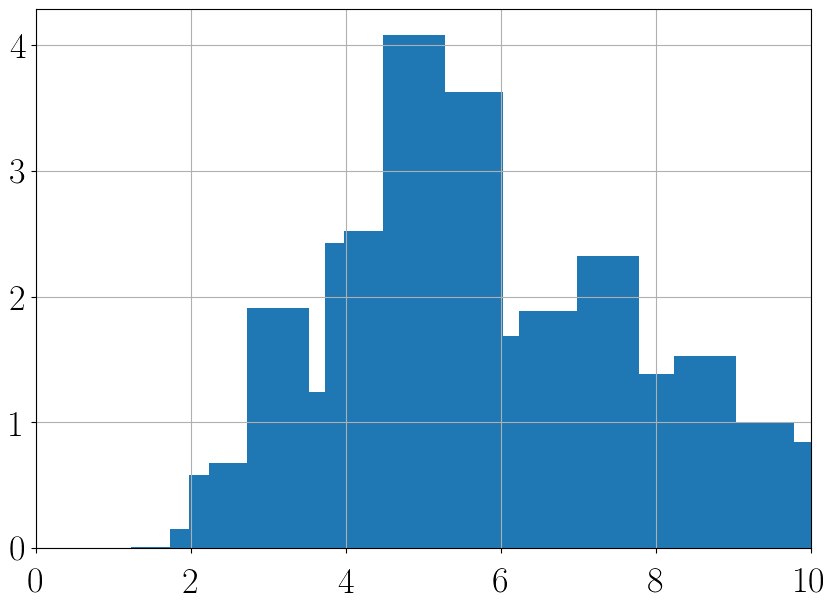

In [14]:
bin_edges   = np.arange(0,100,.25)
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2.

mask_x = np.logical_or(trig_flag==1,trig_flag==12)
mask_y = np.logical_or(trig_flag==2,trig_flag==12)

hist_x,_ = np.histogram(snr[:,0][mask_x],bins=bin_edges,weights=weights_energy[mask_x])
hist_y,_ = np.histogram(snr[:,1][mask_y],bins=bin_edges,weights=weights_energy[mask_y])


# plt.hist(snr[:,0][mask_x],bins=bins,color='b')
# plt.xlim([3,8])
# plt.show()
# plt.hist(snr[:,1][mask_y],bins=bins,color='m')
plt.xlim([0,10])
# plt.show()

plt.bar(bin_centers,hist_x+hist_y)
#plt.xlim([0,8])
#plt.ylim([0,4000])
#plt.axhline(8020/20/5,color='r')
#hist_x+hist_y

(3.0, 8.0)

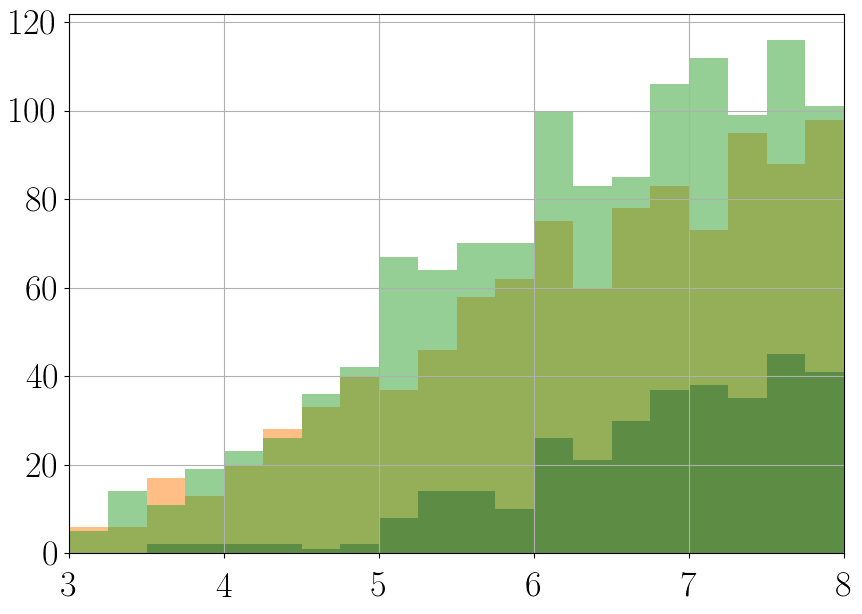

In [15]:
snr_xy_min = np.where( snr[:,0][trig_flag==12] < snr[:,1][trig_flag==12], snr[:,0][trig_flag==12], snr[:,1][trig_flag==12] )
snr_xy_max = np.where( snr[:,0][trig_flag==12] > snr[:,1][trig_flag==12], snr[:,0][trig_flag==12], snr[:,1][trig_flag==12] )

hist,_ = np.histogram(snr_xy_max,bins=bin_edges)
plt.bar(bin_centers,hist,width=.25)
hist,_ = np.histogram(snr[:,0][trig_flag==12],bins=bin_edges)
plt.bar(bin_centers,hist,alpha=.5,width=.25)
hist,_ = np.histogram(snr[:,1][trig_flag==12],bins=bin_edges)
plt.bar(bin_centers,hist,alpha=.5,width=.25)
# hist,_ = np.histogram(np.max( snr[:,0][trig_flag==12],snr[:,1][trig_flag==12] ),bins=bin_edges)
# plt.bar(bin_centers,hist)
plt.xlim([3,8])

In [16]:
entries    = np.arange(len(snr))
entries_x  = entries[trig_flag==1]
entries_y  = entries[trig_flag==2]
entries_xy = entries[trig_flag==12]

snr_hist = np.max( snr[:,:2],axis=1 )
snr_hist = np.where(snr_hist==0,100,snr_hist)

/scratch/users/p/pcorrea/ipykernel_25601/806492135.py:9: RuntimeWarning: divide by zero encountered in log10
  log_hist = np.log10(hist)
/scratch/users/p/pcorrea/ipykernel_25601/806492135.py:14: RuntimeWarning: invalid value encountered in sqrt
  print(pbest,np.sqrt(pcov))


[-0.11736712 -0.31534078] [[0.00663017        nan]
 [       nan 0.0899141 ]]


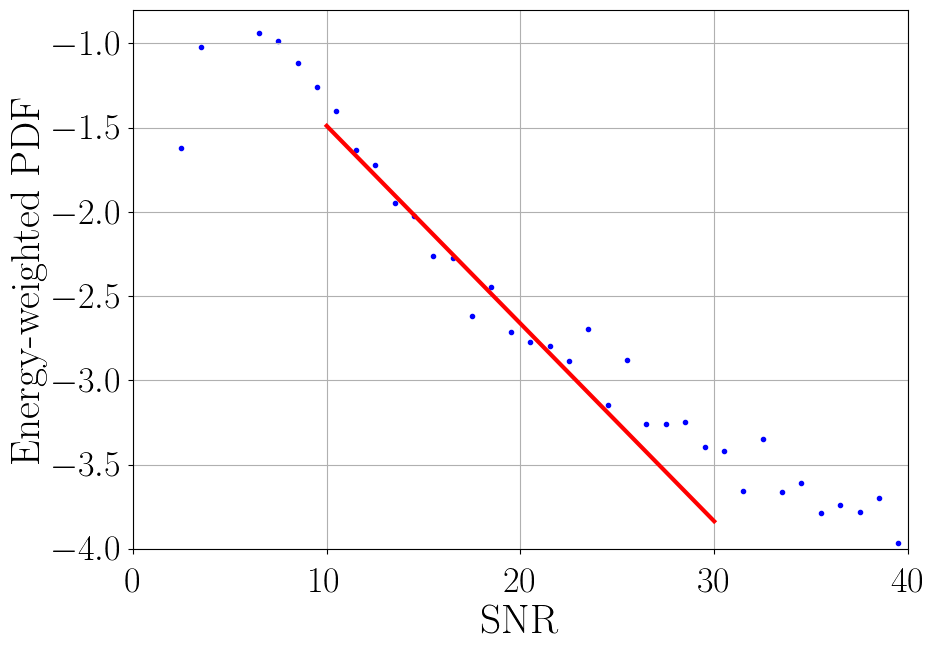

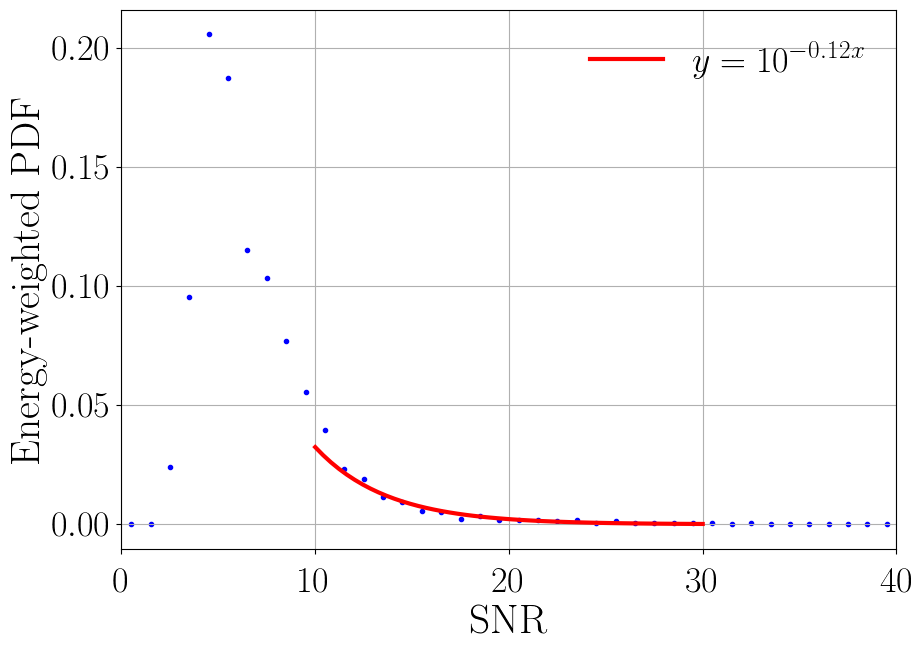

In [17]:
def fit_func(x,a,b):
    return a*x + b


bins = np.arange(0,100)
bin_centers = (bins[1:] + bins[:-1])/2

hist,_ = np.histogram(snr_hist,bins=bins,weights=weights_energy,density=True)
log_hist = np.log10(hist)

pbest, pcov = curve_fit(fit_func,bins[10:30],log_hist[10:30],sigma=1/np.sqrt(hist[10:30]))
fit_label   = r'$y = 10^{' + '{:.2f}'.format(pbest[0]) + r'x}$'

print(pbest,np.sqrt(pcov))

fig, ax = plt.subplots()

ax.scatter(bin_centers,log_hist,color='b')

x = np.linspace(10,30)
ax.plot(x,fit_func(x,pbest[0],pbest[1]),color='r')

ax.set_xlim([0,40])
ax.set_ylim([-4,-.8])

ax.set_xlabel('SNR')
ax.set_ylabel('Energy-weighted PDF')

plt.show()


fig, ax = plt.subplots()

ax.scatter(bin_centers,hist,color='b')

x = np.linspace(10,30)
ax.plot(x,10**fit_func(x,pbest[0],pbest[1]),color='r',label=fit_label)

ax.set_xlim([0,40])

ax.set_xlabel('SNR')
ax.set_ylabel('Energy-weighted PDF')

ax.legend()

plt.show()

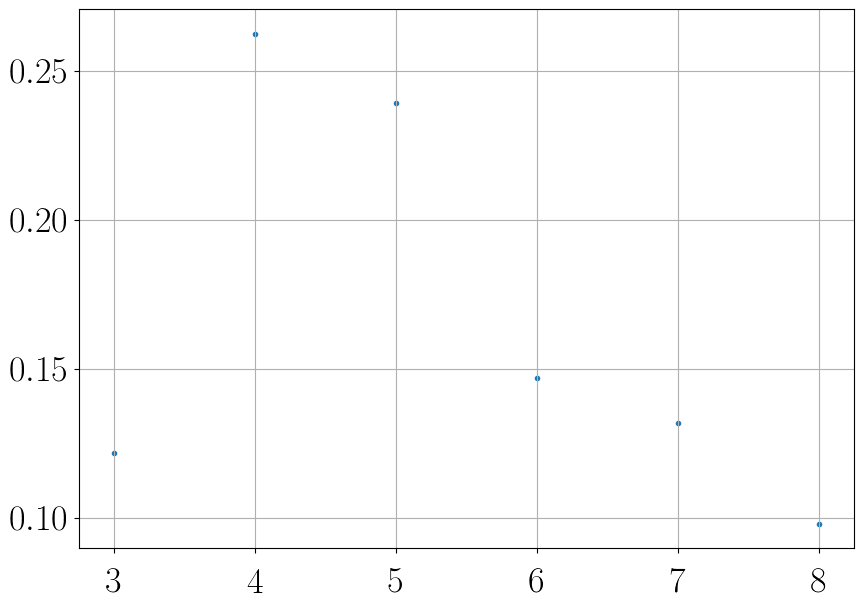

In [37]:
hist,_ = np.histogram(snr_hist,bins=bin_edges,weights=weights_energy,density=True)
hist   = hist/hist.sum()

plt.scatter(bin_edges[:-1],hist)

In [36]:
bin_width = 1
bin_edges = np.arange(3.,9.1,bin_width)
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
which_bin = np.digitize(snr_hist,bins=bin_edges)

idcs_sorted      = np.argsort(which_bin)
entries_sorted   = entries[idcs_sorted] #entries_snr[idcs_sorted]
which_bin_sorted = which_bin[idcs_sorted]
# weights_sorted   = weights_energy[idcs_sorted]

mask_hist      = np.logical_and(which_bin_sorted!=0,which_bin_sorted!=len(bin_edges))
entries_hist   = entries_sorted[mask_hist]
which_bin_hist = which_bin_sorted[mask_hist]

bin_numbers, bin_idcs, bin_counts = np.unique(which_bin_hist,return_index=True,return_counts=True)

In [14]:
hist,_ = np.histogram(snr_hist,bins=bin_edges,weights=weights_energy,density=True)
#hist   = hist/hist.sum()

bin_weights  = hist#10**(-0.09*bin_edges[:-1])
bin_weights /= bin_weights.sum()

n_tot = 8020/5

n_per_bin = n_tot*bin_weights
n_per_bin = n_per_bin.astype(int)

diff = int( n_tot - n_per_bin.sum() )
n_per_bin[:diff] += 1

n_bins = len(n_per_bin)

print(n_per_bin.sum(),bin_weights)


# n_per_bin = int( n_tot/bin_numbers.size )*np.ones(bin_numbers.size,dtype=int)

# diff = int( 8020/5 - np.sum(n_per_bin) )
# n_per_bin[:diff] += 1
# print(n_per_bin)


entries_rand = np.zeros(0,dtype=int)
for i in range(len(bin_numbers)):
    entry_idx_start = bin_idcs[i]
    entry_idx_end   = bin_idcs[i]+bin_counts[i]
    idcs_for_choice = np.arange(entry_idx_start,entry_idx_end)

    if len(idcs_for_choice) < n_per_bin[i]:
        n_missing            = n_per_bin[i] - len(idcs_for_choice)
        n_tot_compensate     = np.sum(n_per_bin[i+1:]) + n_missing
        n_compensate_per_bin = n_missing * (bin_weights[i+1:]/bin_weights[i+1:].sum())

        n_per_bin[i+1:] += n_compensate_per_bin.astype(int)
        diff = int( n_tot_compensate - np.sum(n_per_bin[i+1:])  )

        n_per_bin[i+1:i+1+diff] += 1
        n_per_bin[i] = len(idcs_for_choice)
        print(n_per_bin)
        entries_rand = np.hstack( (entries_rand,entries_hist[idcs_for_choice]) )
    else:
        #weights_bin = weights_sorted[entry_idx_start:entry_idx_end]
        idcs_rand = np.random.choice( idcs_for_choice,size=n_per_bin[i],replace=False) #p=weights_bin/weights_bin.sum()
        entries_rand = np.hstack( (entries_rand,entries_hist[idcs_rand]) )

print(n_per_bin)

1604 [0.07825488 0.07430387 0.07055234 0.06699022 0.06360795 0.06039645
 0.0573471  0.0544517  0.05170249 0.04909208 0.04661347 0.04426
 0.04202536 0.03990354 0.03788885 0.03597588 0.03415949 0.03243482
 0.03079721 0.02924229]
[  9 130 123 117 112 105 100  95  90  86  81  75  72  69  64  61  58  56
  52  49]
[  9   7 134 127 122 114 109 103  98  94  88  81  78  74  69  66  62  60
  56  53]
[  9   7   7 138 133 124 119 112 107 103  96  89  84  80  75  71  67  65
  61  57]
[  9   7   7   4 146 136 130 123 117 113 105  98  91  87  82  77  73  71
  66  62]
[  9   7   7   4   7 149 143 135 129 124 116 108 100  95  90  84  80  77
  72  68]
[  9   7   7   4   7  19 156 148 141 135 127 118 110 104  98  91  87  84
  78  74]
[  9   7   7   4   7  19  31 161 154 147 139 129 120 114 106  99  95  91
  85  80]
[  9   7   7   4   7  19  31  46 167 159 151 140 131 124 115 107 103  98
  92  87]
[  9   7   7   4   7  19  31  46  80 170 161 150 140 132 122 114 110 104
  98  93]
[  9   7   7   4   7  19  

In [15]:
len(snr_hist[np.logical_and(snr_hist>=3,snr_hist<4)])

27

(2.5, 8.5)

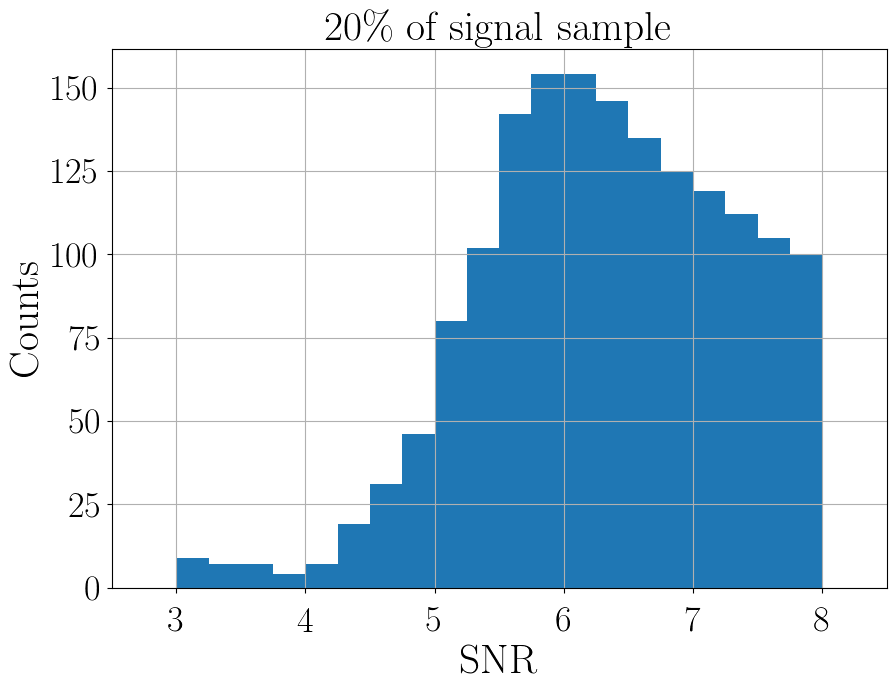

In [16]:
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
plt.hist(snr_hist[entries_rand],bins=bin_edges)
plt.bar(bin_centers,n_per_bin,width=bin_width)
plt.xlabel('SNR')
plt.ylabel('Counts')
plt.title(r'20\% of signal sample')
plt.xlim([2.5,8.5])
#plt.yscale('log')